## 导入Python包

In [47]:
import functools
import torch
import torchvision
import torchmetrics
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
import ray.tune
import os

## 用到的 d2l code

In [48]:
def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

DATA_PATH = 'C:/Users/Public/Documents/Data/kaggle data'

def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return 4


def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
    
def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）

    Defined in :numref:`sec_softmax_scratch`"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(torch.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        torch.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


## homework_code for ch4-sec1

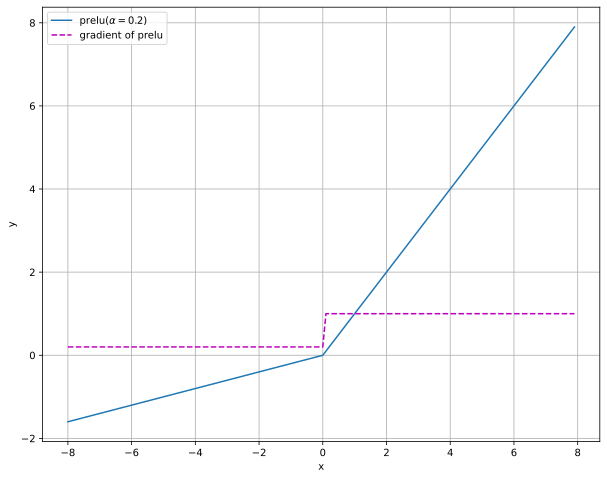

In [49]:
# T1
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.prelu(x, weight=torch.tensor(0.2))
y.backward(torch.ones_like(x), retain_graph=True)
plot([x.detach(), x.detach()], [y.detach(), x.grad], 'x', 'y', legend=[r'prelu($\alpha=0.2$)', 'gradient of prelu'], figsize=(10, 8))

In [50]:
# T3 
a = torch.tensor([-1.5, 2.0, 0.5])
b = torch.tanh(a) + 1
c = 2*torch.sigmoid(2*a) 
b, c, b == c # torch 中，也存在浮点数计算误差，导致判断为False的情况

(tensor([0.0949, 1.9640, 1.4621]),
 tensor([0.0949, 1.9640, 1.4621]),
 tensor([False, False,  True]))

In [51]:
torch.isclose(b, c) # 通过 torch.isclose 来解决这个问题。

tensor([True, True, True])

## Homework_code for ch4-sec2

In [52]:

# 使用ray.tune 调参
# 和sec3 作业代码合并了

## Homework_code for ch4-sec3

In [53]:
# T1 T2 T3
class FlexibleLinear(torch.nn.Module):
    def __init__(self, activation, hidden_layer, 
                layer_nodes, out_features=10, in_features=784, **kwargs):
        super().__init__(**kwargs)
        self.layer = torch.nn.ModuleList([])
        self.layer.append(torch.nn.Flatten())
        In_Feauture = in_features
        for i in range(hidden_layer):
            self.layer.append(torch.nn.Linear(In_Feauture, layer_nodes[i]))
            self.layer.append(activation())
            In_Feauture = layer_nodes[i] 
        self.output = torch.nn.Linear(In_Feauture, out_features=out_features)
    
    def forward(self, x):
        for child in self.layer:
            x = child(x)
        return self.output(x)

LAYER_NODES = {1: (256,), 2: (384, 128), 3: (384, 256, 128)}
ACTIVATION = {'elu': torch.nn.ELU, 'relu': torch.nn.ReLU}
INIT = {'glorot': functools.partial(torch.nn.init.xavier_uniform_, gain=1), 
        'normal': functools.partial(torch.nn.init.normal_, std=0.01)}
search_space = {'lr': ray.tune.loguniform(1e-2, 5e-1),
                'hidden_layer': ray.tune.choice([1, 2, 3]),
                'initializer': ray.tune.choice(['glorot','normal']),
                'activation': ray.tune.choice(['relu', 'elu'])}
BATCH_SIZE, EPOCHS = 256, 10
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
metric = torchmetrics.Accuracy(top_k=1).cuda()

def trainable(config, checkpoint_dir=None):
    net = FlexibleLinear(ACTIVATION[config['activation']], config['hidden_layer'], 
                         LAYER_NODES[config['hidden_layer']])
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            INIT[config['initializer']](m.weight)
    net.apply(init_weights)
    if torch.cuda.device_count() > 1:
        net = torch.nn.DataParallel(net)
    net.cuda()
    trainer = torch.optim.SGD(net.parameters(), lr=config['lr'])
    if checkpoint_dir:
        model_state, trainer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        trainer.load_state_dict(trainer_state)
    for epoch in range(EPOCHS):
        l = 0
        net.train()
        for X, y in train_iter:
            X, y = X.cuda(), y.cuda()
            pred = net(X)
            loss_val = loss(pred, y)
            metric.update(pred, y)
            l += loss_val.item()
            trainer.zero_grad()
            loss_val.backward()
            trainer.step()
        l /= len(train_iter)
        m = metric.compute().item()
        metric.reset()
        net.eval()
        l = 0
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.cuda(), y.cuda()
                pred = net(X)
                loss_val = loss(pred, y)
                metric.update(pred, y)
                l += loss_val.item()
            m = metric.compute().item()
            metric.reset()
            l /= len(test_iter)
        ray.tune.report(accuracy=m, loss=l)
        if epoch % 2 == 0:
            with ray.tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((net.state_dict(), trainer.state_dict()), path)

analysis = ray.tune.run(trainable, 
                        config=search_space, 
                        resources_per_trial={"cpu": 20, "gpu": 2},
                        num_samples=150,
                        name='homework_ch4',
                        metric='accuracy',
                        mode='max',
                        log_to_file= True,
                        local_dir='./ray_result',
                        scheduler=ray.tune.schedulers.ASHAScheduler(
                                            max_t=50,
                                            grace_period=5,
                                            reduction_factor=2),
                        verbose=0,
                        max_failures=1,
                        resume='AUTO')

2022-06-01 17:27:39,490	INFO trial_runner.py:803 -- starting trainable_564a4_00062
(pid=) 2022-06-01 17:27:39,514	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" Z:\User\Documents\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=60032 --object-store-name=tcp://127.0.0.1:64867 --raylet-name=tcp://127.0.0.1:63345 --redis-address=None --storage=None --temp-dir=C:\Users\zhulei\AppData\Local\Temp\26\ray --metrics-agent-port=61287 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:60800 --redis-password=5241590000000000 --startup-token=231 --runtime-env-hash=-354594111
2022-06-01 17:27:40,489	WARNING util.py:171 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.
(trainable pid=18304) C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
(trainable pid=18304

In [54]:
print(analysis.get_best_config())

{'lr': 0.16400486478184217, 'hidden_layer': 2, 'initializer': 'glorot', 'activation': 'elu'}


In [55]:
overall = analysis.dataframe()[['accuracy', 'loss', 'config/activation', 'config/hidden_layer', 'config/initializer', 'config/lr']]
overall['activation'] = overall['config/activation'].map(lambda s: 1 if s == 'elu' else 0)
overall['initializer'] = overall['config/initializer'].map(lambda s: 1 if s == 'normal' else 0)
overall

,accuracy,loss,config/activation,config/hidden_layer,config/initializer,config/lr,activation,initializer
0,0.8312,4.707279e-01,elu,1,glorot,0.028701,1,0
1,0.6607,8.518477e-01,elu,3,normal,0.043959,1,1
2,0.1000,5.981447e+02,elu,2,glorot,0.390733,1,0
3,0.4389,1.707925e+00,relu,2,glorot,0.422708,0,0
4,0.8376,4.555428e-01,elu,2,glorot,0.019299,1,0
...,...,...,...,...,...,...,...,...
145,0.8347,4.611974e-01,relu,3,glorot,0.311050,0,0
146,0.7401,7.025358e-01,elu,3,normal,0.096380,1,1
147,0.1000,NaN,elu,3,glorot,0.259791,1,0
148,0.8278,4.950352e-01,relu,1,glorot,0.014867,0,0


<AxesSubplot:xlabel='config/lr', ylabel='accuracy'>

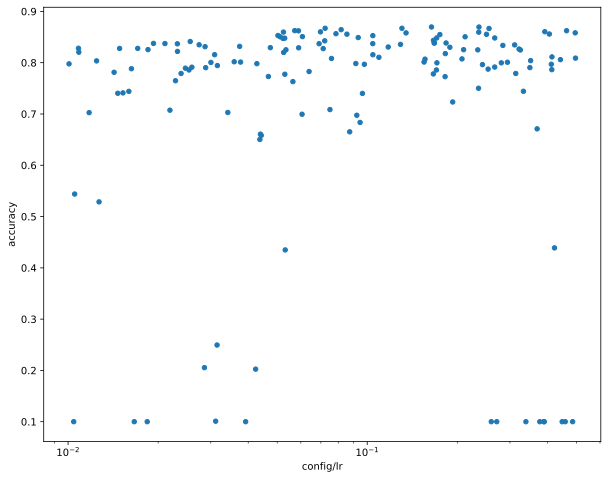

In [56]:
overall.plot(x='config/lr', y='accuracy', logx=True, kind='scatter')

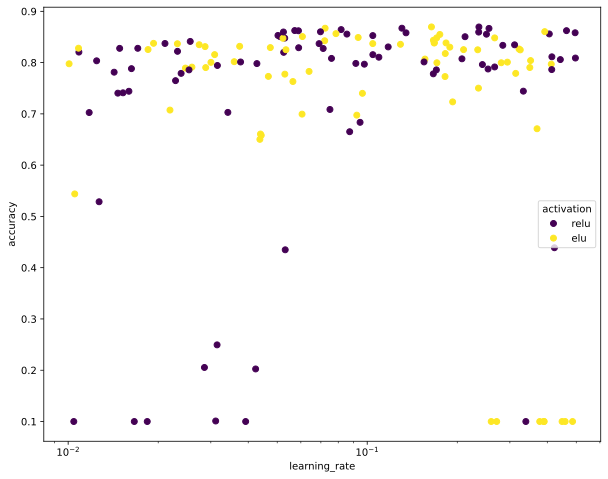

In [57]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='activation')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(scatter.legend_elements()[0], ['relu', 'elu'], title='activation')
plt.show()

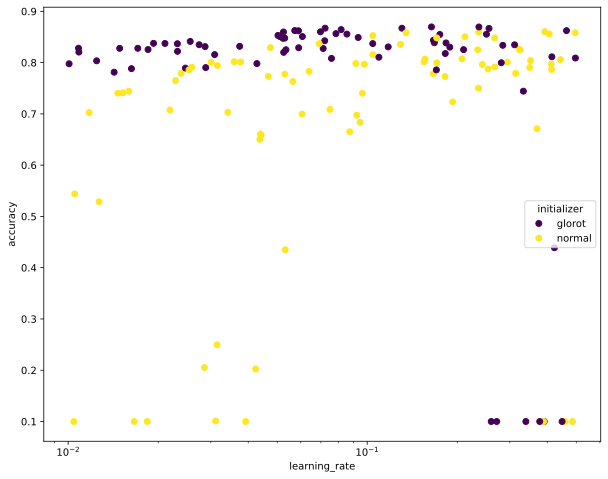

In [58]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='initializer')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(scatter.legend_elements()[0], ['glorot', 'normal'], title='initializer')
plt.show()

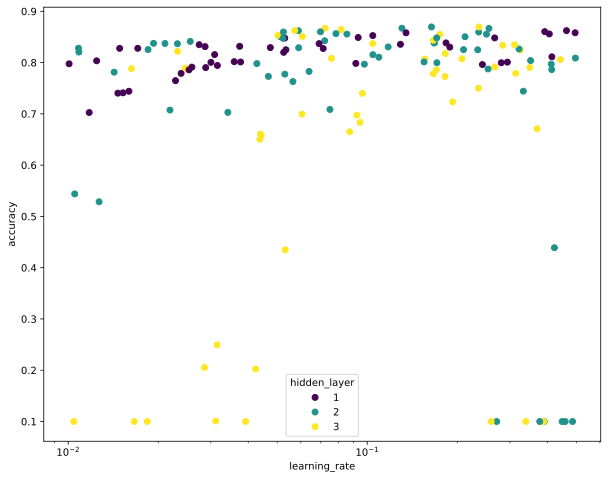

In [59]:
scatter = plt.scatter(data=overall, x='config/lr', y='accuracy', c='config/hidden_layer')
plt.gca().set_xscale('log')
plt.gca().set_xlabel('learning_rate')
plt.gca().set_ylabel('accuracy')
plt.legend(*scatter.legend_elements(), title='hidden_layer')
plt.show()

## Homework_code for ch4-sec4

In [60]:
def polynomial_transform(x, pow):
    _x = torch.zeros_like(x)
    for i in range(2, pow+1):
        _x = torch.cat((_x, _x[:, -1].reshape(-1,1)*_x[:, 0].reshape(-1,1)/i), dim=1)
    return _x


def synthetic_polynomial(w, b, num_examples):
    x = torch.normal(0, 2, (num_examples, 1))
    y = torch.matmul(polynomial_transform(x, len(w)), w) + b + torch.normal(0, 0.1, (num_examples,))
    return x, torch.reshape(y, (-1, 1))


def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [61]:
true_w, true_b = torch.tensor([-4., 3.4, -1.6, 1.2]), 5
X, Y = synthetic_polynomial(true_w, true_b, 500)
Poly_X = polynomial_transform(X, 10)
train_iter, val_iter = load_array((Poly_X[:400], Y[:400]), 16), load_array((Poly_X[400:], Y[400:]), 4, False)


In [62]:
class PolynomialRegressor(torch.nn.Module):
    def __init__(self, pow, out=1, **kwargs):
        super().__init__(**kwargs)
        self.model = torch.nn.Linear(pow, out)
    
    def forward(self, x):
        return self.model(x)
    


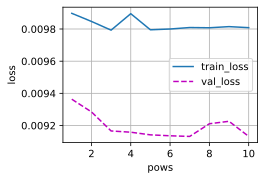

In [63]:
# T2
loss = torch.nn.MSELoss()
train_loss = []
validate_loss = []

for pows in range(1, 11):
    net = PolynomialRegressor(pows)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    net.train()
    for epoch in range(3):
        for x, y in train_iter:
            pred = net(x[:, :pows])
            loss_val = loss(pred, y)
            trainer.zero_grad()
            loss_val.backward()
            trainer.step()
    net.eval()
    with torch.no_grad():
        train_x, train_y = train_iter.dataset[:]
        val_x, val_y = val_iter.dataset[:]
        train_loss.append(loss(net(train_x[:, :pows]), train_y).item())
        validate_loss.append(loss(net(val_x[:, :pows]), val_y).item())

plot(list(range(1, 11)), [train_loss, validate_loss], 'pows', 'loss', legend=['train_loss', 'val_loss'])


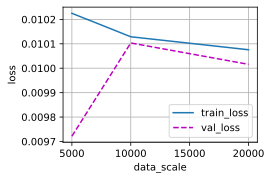

In [64]:
loss = torch.nn.MSELoss()
train_loss = []
validate_loss = []

for datanum in [5000, 10000, 20000]:
    net = PolynomialRegressor(4)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    X, Y = synthetic_polynomial(true_w, true_b, datanum)
    Poly_X = polynomial_transform(X, 4)
    split = int(datanum*0.8)
    train_iter, val_iter = load_array((Poly_X[:split], Y[:split]), 16), load_array((Poly_X[split:], Y[split:]), 4, False)
    net.train()
    for epoch in range(3):
        for x, y in train_iter:
            pred = net(x)
            loss_val = loss(pred, y)
            trainer.zero_grad()
            loss_val.backward()
            trainer.step()
    net.eval()
    with torch.no_grad():
        train_x, train_y = train_iter.dataset[:]
        val_x, val_y = val_iter.dataset[:]
        train_loss.append(loss(net(train_x), train_y).item())
        validate_loss.append(loss(net(val_x), val_y).item())

plot(([5000, 10000, 20000]), [train_loss, validate_loss], 'data_scale', 'loss', legend=['train_loss', 'val_loss'])

## homework_code for ch_5

In [65]:
true_w, true_b = torch.tensor([-4., 3.4, -1.6, 1.2]), 5
X, Y = synthetic_polynomial(true_w, true_b, 500)
Poly_X = polynomial_transform(X, 10)
train_iter, val_iter = load_array((Poly_X[:400], Y[:400]), 16), load_array((Poly_X[400:], Y[400:]), 4, False)
loss = torch.nn.MSELoss()

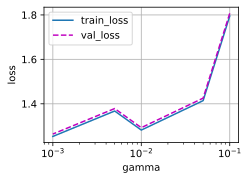

In [66]:
train_loss, validate_loss = [], []
for gamma in [0.1, 0.05, 0.01, 0.005, 0.001]:
    net = PolynomialRegressor(10)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    net.train()
    for epoch in range(3):
        for x, y in train_iter:
            pred = net(x)
            loss_val = loss(pred, y)
            for param in net.parameters():
                loss_val += gamma*torch.sum(torch.square(param))
            trainer.zero_grad()
            loss_val.backward()
            trainer.step()
    net.eval()
    with torch.no_grad():
        train_x, train_y = train_iter.dataset[:]
        val_x, val_y = val_iter.dataset[:]
        train_loss.append(loss(net(train_x), train_y).item())
        validate_loss.append(loss(net(val_x), val_y).item())

plot([0.1, 0.05, 0.01, 0.005, 0.001], [train_loss, validate_loss], 'gamma', 'loss', legend=['train_loss', 'val_loss'], xscale='log')


## Homework_code for ch4-sec6

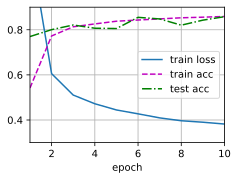

In [67]:
# T1
BATCH_SIZE, EPOCHS = 256, 10
dropout1, dropout2 = 0.5, 0.2
loss = torch.nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          torch.nn.Dropout(dropout1),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          torch.nn.Dropout(dropout2),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

train_ch3(net, train_iter, test_iter, loss, EPOCHS, trainer)

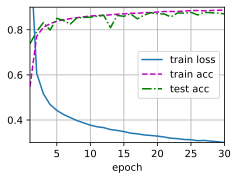

In [68]:
# T2
BATCH_SIZE, EPOCHS = 256, 30
dropout1, dropout2 = 0.5, 0.2
loss = torch.nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          torch.nn.Dropout(dropout1),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          torch.nn.Dropout(dropout2),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

train_ch3(net, train_iter, test_iter, loss, EPOCHS, trainer)

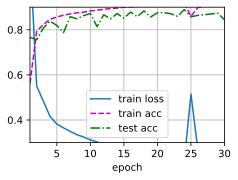

In [69]:
BATCH_SIZE, EPOCHS = 256, 30
dropout1, dropout2 = 0, 0
loss = torch.nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          torch.nn.Dropout(dropout1),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          torch.nn.Dropout(dropout2),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

train_ch3(net, train_iter, test_iter, loss, EPOCHS, trainer)

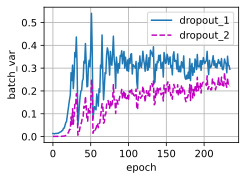

In [70]:
# T3
class DropoutWithVar(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.dropout = torch.nn.Dropout(**kwargs)
        self.var_lst = []
    
    def forward(self, x):
        if self.training:
            x = self.dropout(x)
            self.var_lst.append(torch.var(x).item())
        return x


BATCH_SIZE, EPOCHS = 256, 3
dropout1, dropout2 = 0.5, 0.2
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),
                          torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          DropoutWithVar(p=dropout1),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          DropoutWithVar(p=dropout2),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
for epoch in range(EPOCHS):
    for x, y in train_iter:
        pred = net(x)
        loss_val = loss(pred, y)
        trainer.zero_grad()
        loss_val.backward()
        trainer.step()
    net.eval()
    with torch.no_grad():
        for x, y in test_iter:
            pred = net(x)
            loss_val = loss(pred, y)

y =[]
for layer in net.children():
    if hasattr(layer, 'var_lst'):
        y.append(layer.var_lst)

plot(X=y, legend=['dropout_1', 'dropout_2'], ylabel='batch_var', xlabel='epoch')


AssertionError: 0.7360766277949016

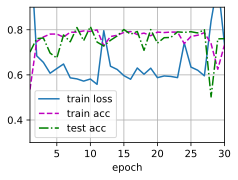

In [71]:
# T5 dropout_with_weight_decayed
BATCH_SIZE, EPOCHS = 256, 30
dropout1, dropout2 = 0.2, 0.5
loss = torch.nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          torch.nn.Dropout(dropout1),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          torch.nn.Dropout(dropout2),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5, weight_decay=0.005)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

train_ch3(net, train_iter, test_iter, loss, EPOCHS, trainer)

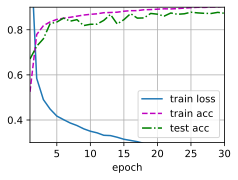

In [ ]:
# T7
class NoisyLayer(torch.nn.Module):
    def __init__(self, sigma, **kwarg):
        super().__init__(**kwarg)
        self.sigma = sigma
    
    def forward(self, x):
        if self.training:
            x = x + torch.normal(0, self.sigma, x.shape)
        return x

BATCH_SIZE, EPOCHS = 256, 30
loss = torch.nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(BATCH_SIZE)
net = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(784, 256),torch.nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层 
                          NoisyLayer(0.25),
                          torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
                          NoisyLayer(0.25),
                          torch.nn.Linear(256, 10))
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

train_ch3(net, train_iter, test_iter, loss, EPOCHS, trainer)